# Geant4 gain calibration testing (cant believe im making a notebook)

In [1]:
import numpy as np
import numpy.polynomial.polynomial as pn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import Markdown, display
import os
import sys

# make a nice interactive thing
%matplotlib notebook

In [2]:
# kill the plots
plt.close('all')
plt.ion()
None

## Set files

In [3]:
proj_base = f'{os.getenv("HOME")}/grad_school/glesener/geant/impress'
element = f'{proj_base}/helper-scripts/plot-cryst-or-si/ba133.txt'
base_g4_file = f'{proj_base}/oral-exam/ba133-compare/ba133-cryst-scint-300k/{{}}-{{}}-out.tab'

attenuator = 'c1'
si_file = base_g4_file.format(attenuator, 'si')
cryst_file = base_g4_file.format(attenuator, 'cryst')

in_energies, in_intensities = np.loadtxt(element, unpack=True)
geant_si_counts = np.loadtxt(si_file)
geant_cryst_counts, _ = np.loadtxt(cryst_file, unpack=True)

## Pick bins to fit

<IPython.core.display.Javascript object>


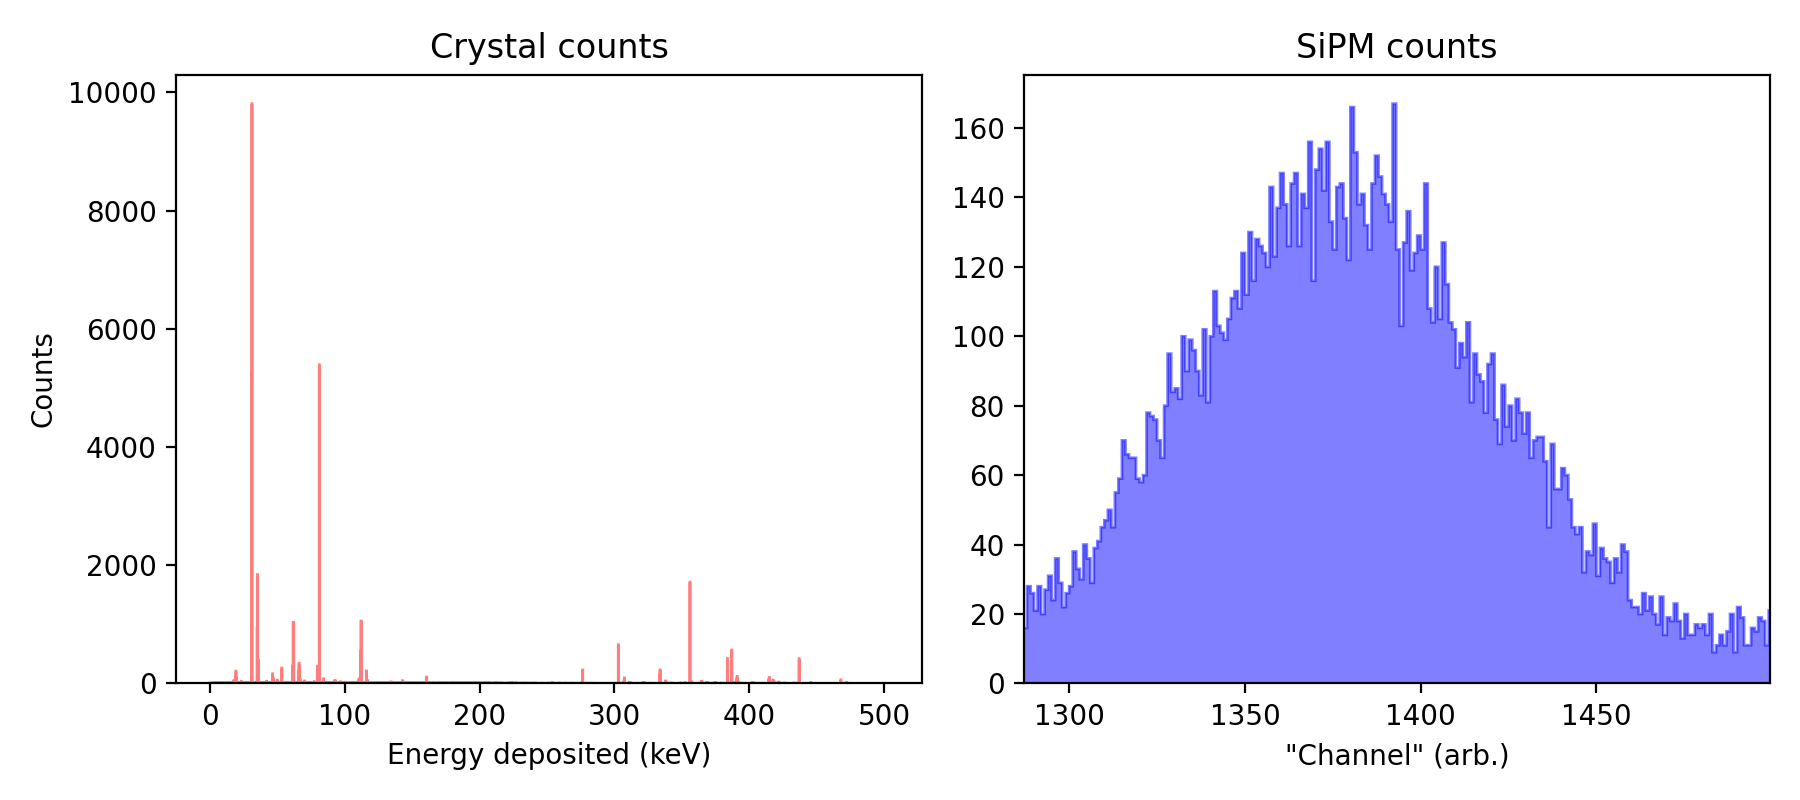

In [4]:
si_bins = np.arange(np.max(geant_si_counts))
cr_bins = np.linspace(0, np.max(geant_cryst_counts), num=si_bins.size)

fig, (crax, siax) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
geant_hg, _, _ = siax.hist(
    geant_si_counts, bins=si_bins, color='blue', edgecolor='blue',
    alpha=0.5, histtype='stepfilled'
)
plot_pts = si_bins[:-1] + np.diff(si_bins)*0.5
crax.hist(
    geant_cryst_counts, bins=cr_bins, color='red', edgecolor='red',
    alpha=0.5, histtype='stepfilled'
)

siax.set_title('SiPM counts')
siax.set_xlabel('"Channel" (arb.)')

crax.set_title('Crystal counts')
crax.set_xlabel('Energy deposited (keV)')
crax.set_ylabel('Counts')
plt.gcf().tight_layout()
plt.show()

In [5]:
bin_ranges = [
    [1300, 1450],
    [3400, 3800],
    [1500, 1700]
]

## ...  and their corresponding energies

<IPython.core.display.Javascript object>


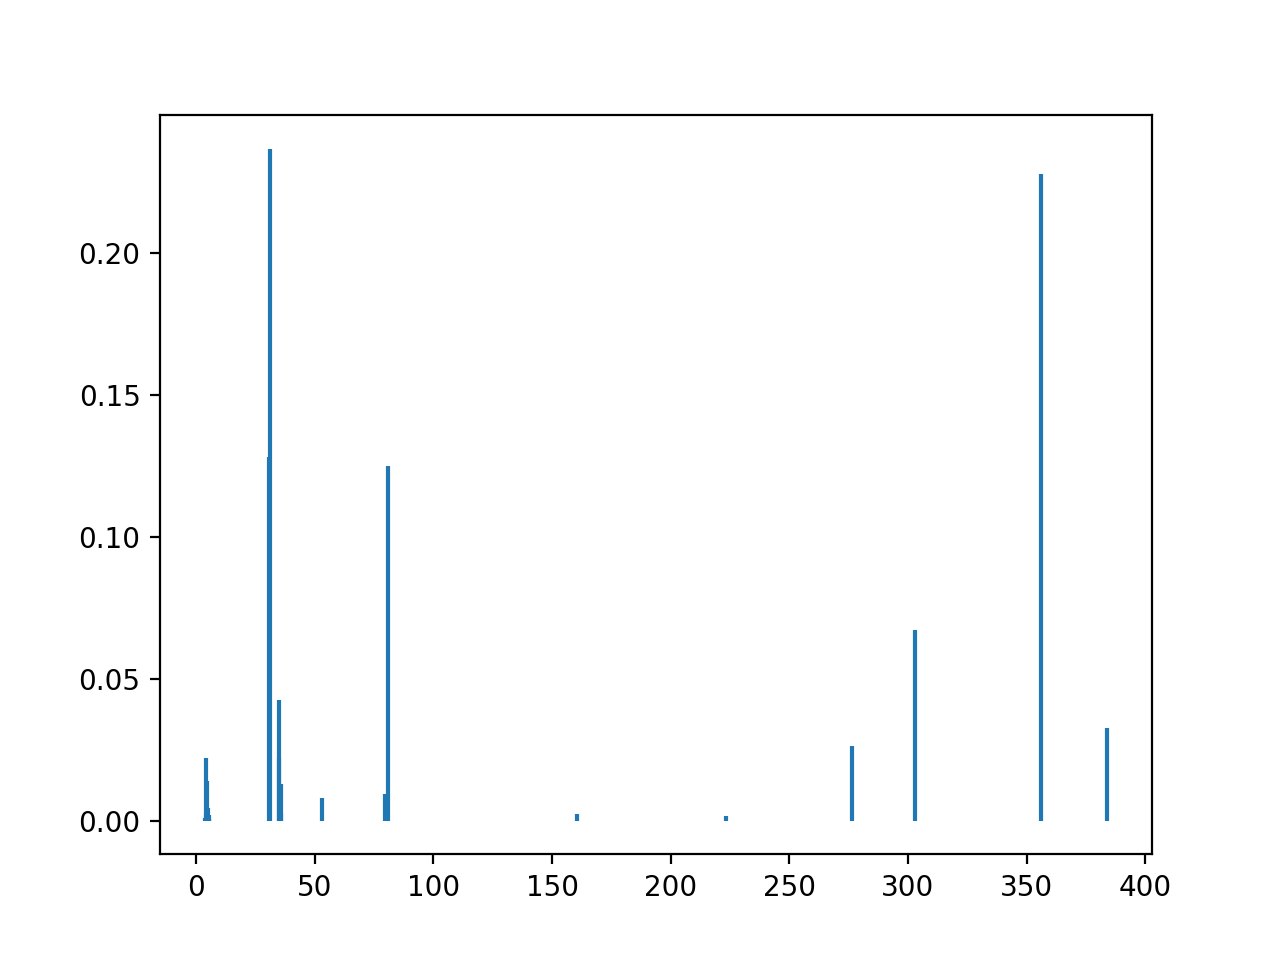

sorted by intensity (pick the index)
30.97  keV (14 ) [@ 23.68%]
356.02 keV (27 ) [@ 22.78%]
30.62  keV (13 ) [@ 12.81%]
81.00  keV (22 ) [@ 12.51%]
302.85 keV (26 ) [@ 6.73 %]
34.99  keV (16 ) [@ 4.26 %]
383.85 keV (28 ) [@ 3.28 %]
276.40 keV (25 ) [@ 2.63 %]
4.29   keV (3  ) [@ 2.20 %]
34.92  keV (15 ) [@ 2.20 %]
4.62   keV (4  ) [@ 1.40 %]
35.82  keV (18 ) [@ 1.31 %]
79.61  keV (21 ) [@ 0.96 %]
53.16  keV (20 ) [@ 0.81 %]
4.93   keV (8  ) [@ 0.44 %]
4.72   keV (6  ) [@ 0.34 %]
35.91  keV (19 ) [@ 0.27 %]
4.27   keV (2  ) [@ 0.24 %]
160.61 keV (23 ) [@ 0.24 %]
4.65   keV (5  ) [@ 0.21 %]
5.28   keV (9  ) [@ 0.20 %]
223.23 keV (24 ) [@ 0.17 %]
3.79   keV (0  ) [@ 0.09 %]
5.55   keV (11 ) [@ 0.08 %]
5.54   keV (10 ) [@ 0.06 %]
35.25  keV (17 ) [@ 0.05 %]
4.14   keV (1  ) [@ 0.04 %]
4.78   keV (7  ) [@ 0.02 %]
30.27  keV (12 ) [@ 0.00 %]


In [6]:
fig, ax = plt.subplots()
ax.vlines(x=in_energies, ymin=0, ymax=in_intensities)
plt.show()

intens = in_intensities / np.sum(in_intensities)
sorted_indices = np.argsort(intens)[::-1]
srt_eng = in_energies[sorted_indices]
print('sorted by intensity (pick the index)')

for i, e in zip(sorted_indices, srt_eng):
    print(f'{e:<6.2f} keV ({i:<3}) [@ {100 * intens[i]:<5.2f}%]')

In [7]:
# indices from above (for the peaks we want)
energy_indices = np.array([
    14, 22, 16
])
selected_energies = in_energies[energy_indices]

## Get some good initial fit guesses

In [8]:
def gaussian_shape(x, amp, center, scale):
    exponent = -((x - center)**2 / scale)
    return amp * np.exp(exponent)

<IPython.core.display.Javascript object>


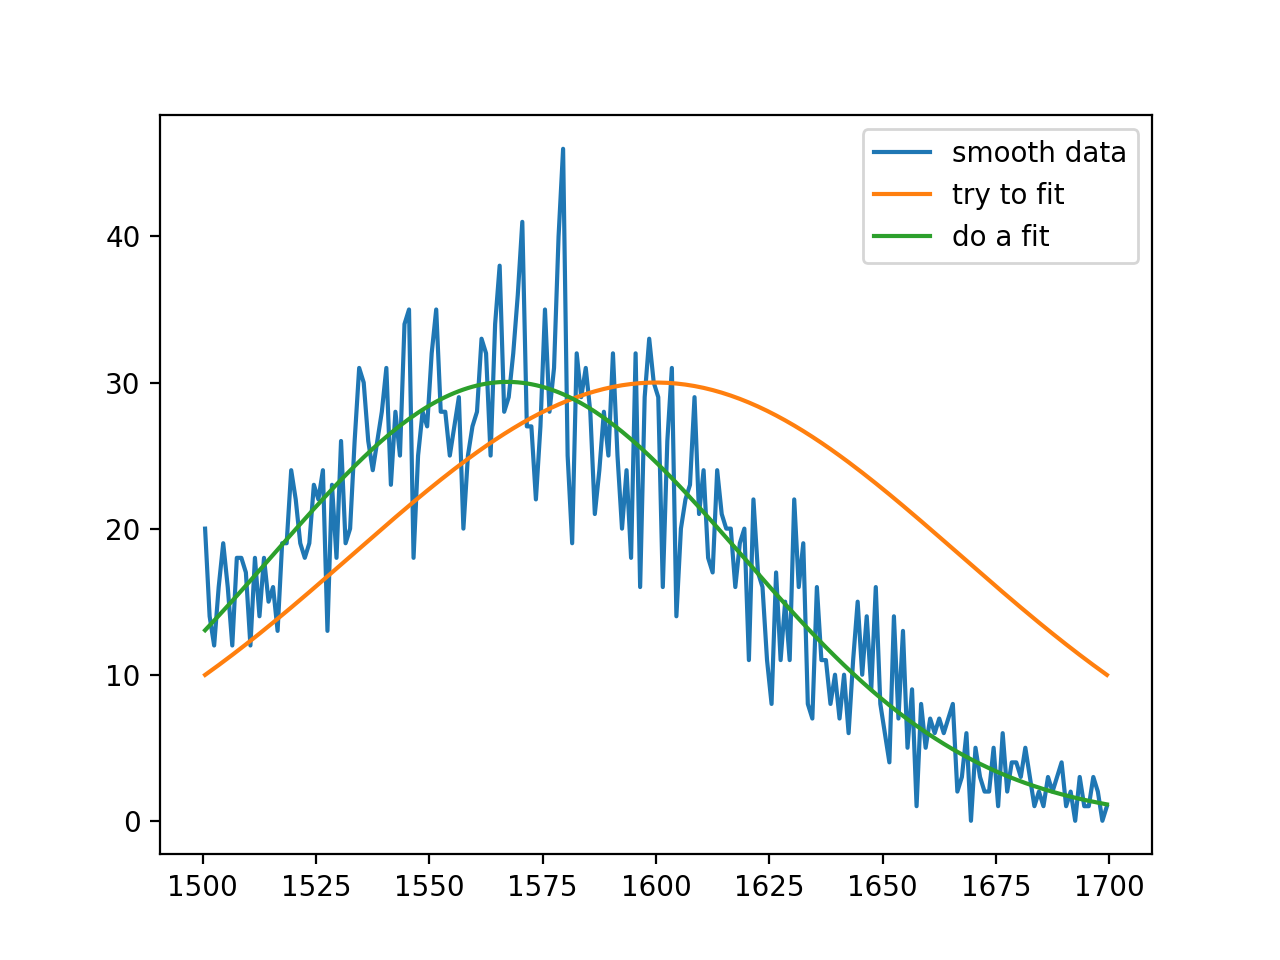

params [  30.0443706  1567.17714394 5329.15065002]
errors [  0.55290923   1.22066631 284.43891787]


In [9]:
guess_idx = 2
guess_params = [30, 1600, 9000]

bin_range, e = bin_ranges[guess_idx], selected_energies[guess_idx]
s = slice(*bin_range)
da_slice = geant_hg[s]
fig, ax = plt.subplots()
ks = 1
smooth = np.convolve(np.ones(ks) / ks, da_slice, mode='same')
popt, pcov = curve_fit(
    gaussian_shape, plot_pts[s], smooth, p0=guess_params)

print('params', popt)
print('errors', np.sqrt(np.diag(pcov)))
ax.plot(plot_pts[s], smooth, label='smooth data')
ax.plot(plot_pts[s], gaussian_shape(plot_pts[s], *guess_params), label='try to fit')
ax.plot(plot_pts[s], gaussian_shape(plot_pts[s], *popt), label='do a fit')
ax.legend()
plt.show()

In [10]:
good_guesses = [
    [142, 1380, 4000],
    [28, 3600, 16666],
    [30, 1570, 5300]
]

## Now we can do the actual gain calibration

## Now do the fits and extract the peaks

In [11]:
zipped = zip(selected_energies, bin_ranges, good_guesses)
centers = []
for i, (peak_energy, slice_range, param_guess) in enumerate(zipped):
    slc = slice(*slice_range)
    sliced_counts, sliced_hist = plot_pts[slc], geant_hg[slc]
    paramz, _ = curve_fit(
        gaussian_shape, xdata=sliced_counts, ydata=sliced_hist,
        p0=param_guess)
    centers.append(paramz[1])
    print(f'center {i} is {centers[i]:.3e}')

center 0 is 1.377e+03
center 1 is 3.610e+03
center 2 is 1.567e+03


In [12]:
pol = pn.Polynomial.fit(
    x=centers,
    y=selected_energies,
    deg=1
)
intercept, slope = pol.convert().coef
print(intercept, slope)

-0.05830506748028341 0.022450715102568543


## Test it out

# Best fit line: $E = -0.05831 + 0.02245\text{channel}$

<IPython.core.display.Javascript object>


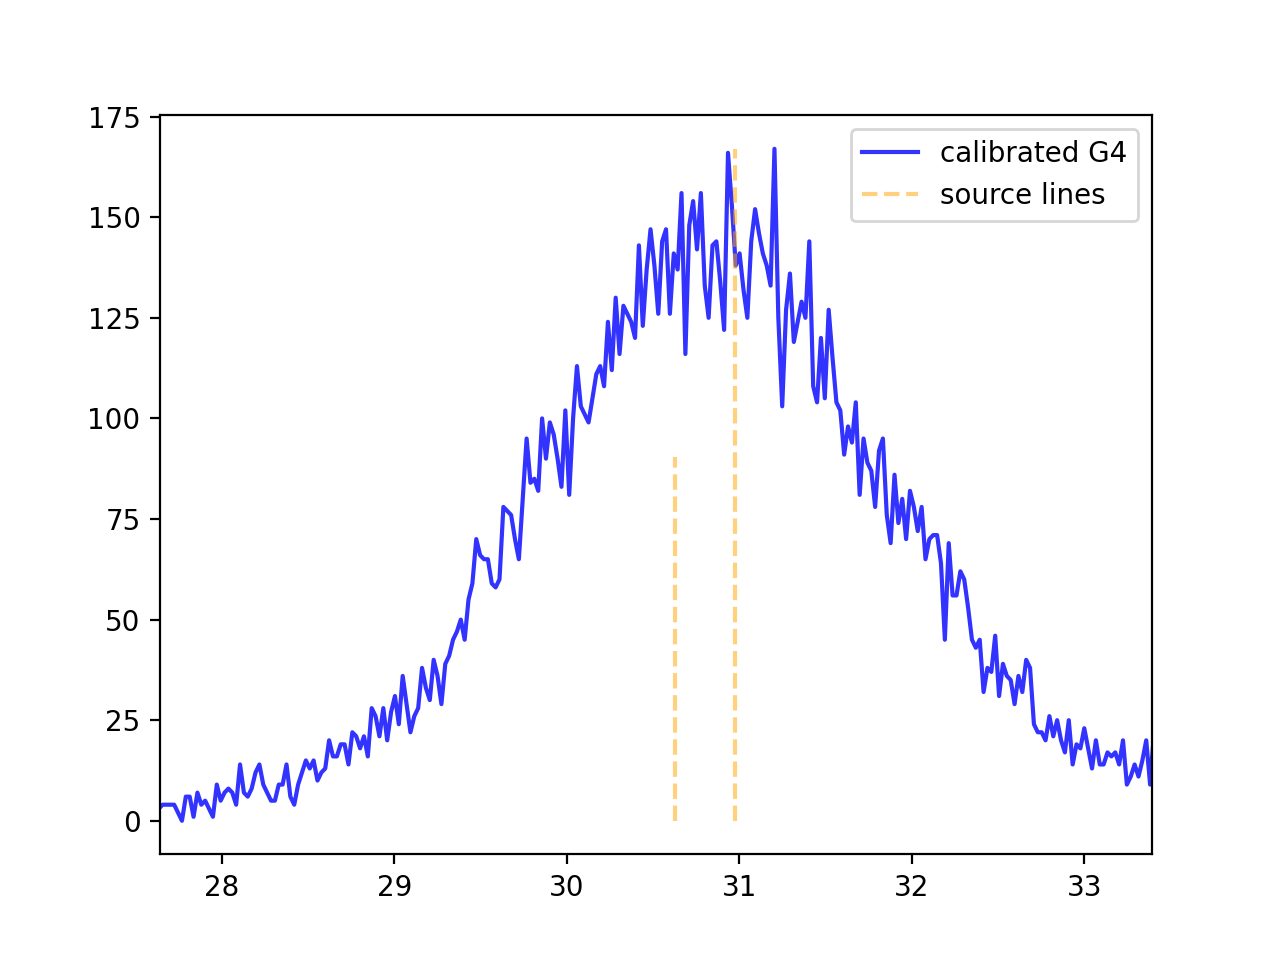

In [13]:
display(Markdown(f"# Best fit line: $E = {intercept:.5f} + {slope:.5f}\\text{{channel}}$"))

calibrated_plot_pts = intercept + slope*plot_pts
fig, ax = plt.subplots()
ax.plot(calibrated_plot_pts, geant_hg, color='blue', alpha=0.8, label='calibrated G4')
# ax.fill_between(calibrated_plot_pts, geant_hg, color='blue', alpha=0.2)
ax.vlines(
    x=in_energies, ymin=0,
    ymax=in_intensities * np.max(geant_hg) / np.max(in_intensities),
    label='source lines', linestyle='dashed', alpha=0.5, color='orange')

ax.legend()
plt.show()